## **Reinforcement Learning**

In [ ]:
!pip install --upgrade tensorflow

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

### Intro to OpenAI gym

In [2]:
import gym

In [3]:
# lists all available environments
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [4]:
env = gym.make("CartPole-v1")

In [5]:
# initialize by resetting the environment
obs = env.reset()

In [6]:
# obs returns horizontal position, velocity, angle of the pole, and angular velocity
obs

array([ 0.037735  ,  0.00373405, -0.01631524,  0.03655894])

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

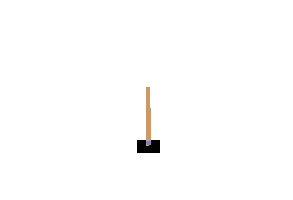

In [8]:
# render works on local, but on colab
env.render()
env.close()

def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [9]:
env.close()

In [10]:
# env has two actionsm left(0) or right(1)
env.action_space


Discrete(2)

In [11]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([ 0.03780968,  0.19908612, -0.01558406, -0.26122663])

In [12]:
# reward returns the reward during the last step
reward

1.0

In [13]:
# whether game is over
done

False

In [14]:
# when more information is available, provided in dict format
info

{}

### A simple hard-coded policty to remain poll upright

In [15]:
# when pole is tilted to the left, then push the cart to the left, and vice versa

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []

for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [16]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.11, 9.156303839432153, 24.0, 68.0)

In [17]:
## visualization

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [53]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


In [18]:

plot_animation(frames)

### Neural Network Policies

- this env is noise free and contains the env's full state. However, if there are hidden state, one needs to infer the hidden state. And if the observations are noisy, may have to consider the past few observations

In [19]:
# neural network will return probability p of action 0(left), 
# and choose action between 0 and 1 with prob p and 1-p
# this adds some randomness to the model, and balance betwwen exploring and exploiting the model

n_inputs = 4 # env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [20]:
# play one episode, and return frams to display

def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [21]:
frames = render_policy_net(model)
plot_animation(frames)

In [22]:
# that was pretty bad..
# use 50 diff environments in parallel and train for 5000 iterations

n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, proba(left) = 1, else proba(left) = 0
    target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

    for env in envs:
        env.close()

Iteration: 4999, Loss: 0.114

In [23]:
frames = render_policy_net(model)
plot_animation(frames)

### Policy Gradients

In [24]:
# because most actions have delayed effects, it is not clear which action contributed to this result
# which is credit assignment problem

# policy gradient algorithm makes actions in good episodes more likely, and bad episodes less likely
# it computes gradients as if all actions are right, and weight them according to the results

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads


In [25]:
# function to play multiple episodes

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [26]:
# PG algorithm uses the model to play several episodes then goes back to look at all rewards,
# and discounts them and normalized them

def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                             for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
           for discounted_rewards in all_discounted_rewards]

In [27]:
# i.e.
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [28]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [29]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [30]:
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid")
])

In [42]:
# run episodes
env = gym.make("CartPole-v1")

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.1f}".format(
        iteration, total_rewards / n_episodes_per_update), end="")
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
            for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 25, mean rewards: 26.4

Exception ignored in: <function Viewer.__del__ at 0x000002828A571678>
Traceback (most recent call last):
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\DooDoo\Anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x00000282A0BB6BD8; to 'Win32Window' at 0x000002828A4EDB48>,)


Iteration: 149, mean rewards: 168.8

In [44]:
frames = render_policy_net(model)
plot_animation(frames)

### Markov Chains

In [31]:
# markov chains always have a settlement state

transition_probabilities = [ # shape=[s, s']
    [0.7, 0.2, 0.0, 0.1], # from s0 to s0, s1, s2, s3
    [0.0, 0.0, 0.9, 0.1], # from s1 to ...
    [0.0, 1.0, 0.0, 0.0], # from s2 to ...
    [0.0, 0.0, 0.0, 1.0], # from s3 to ...
]

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()
    

States: 0 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 1 2 1 3 
States: 0 0 0 0 0 0 0 0 0 0 3 
States: 0 0 0 0 3 
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


### Markov Decision Process

In [32]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

### Q-Value Iteration

In [33]:
# using Q value to evaluate the policy and best state
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # all possible actions

In [34]:
gamma = 0.90 # discount factor

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp]
                * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

history1 = np.array(history1)

In [35]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [36]:
# best state for each
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

In [37]:
# yet the optimal action changes with different discount factor
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # all possible actions
    
gamma = 0.95 # discount factor

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp]
                * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

history1 = np.array(history1)

Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [38]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

### Q-Learning

In [39]:
# Q learning let the agent play and gradually improve its esimates of Q values.
# once it has accurate Q value estimates, then the optimal policy is the one with the highest q value

# simulate agent moving around in the environment
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [40]:
# exploration policy ( random policy to visit every possible states)
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [41]:
# initialize Q-value and run the Q-learning algorithm
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

In [42]:
Q_values

array([[18.83084058, 17.29379225, 13.85379786],
       [ 0.        ,        -inf, -7.76420275],
       [       -inf, 49.3920094 ,        -inf]])

In [43]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1], dtype=int64)

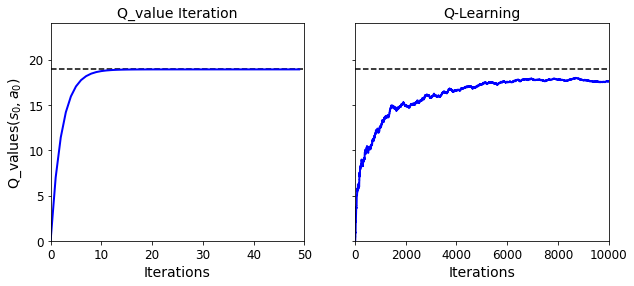

In [79]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q_values$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q_value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)

for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

### Deep Q-Network

In [44]:
# deep Q-learning, uses DQN

env = gym.make("CartPole-v1")
input_shape = [4] # env.observation_space.shape
n_outputs = 2 # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [45]:
# DQN chooses the largest predicted Q value, but to let agent explore, 
# choose random action with probability epsilon

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [46]:
# we also need replay memory
from collections import deque

replay_memory = deque(maxlen=2000)

In [47]:
# function to sample experiences, returns 5 numpy arrays 
# [obs, actions, rewards, next_obs, dones]

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [48]:
# function to use DQN to play one step and record its experience
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [49]:
# function to sample some experiences from the replay memory and perform training step

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                      (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) # 1 dimensional
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [92]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step+1, epsilon),
         end="")
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

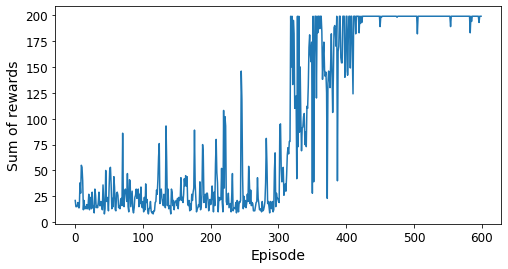

In [93]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [94]:
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

### Fixed Q-value Target

In [51]:
# DQL uses DQN model to predict and set target, hence there may exist circular feedback problem
# hence use two DQNs
# one to train and move agent(online model)
# and one to just define the target(which is the copy of online model)

env = gym.make("CartPole-v1")
input_shape = [4] # env.observation_space.shape
n_outputs = 2 # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

# make target model

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [52]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.mean_squared_error

# next Q values are predicted by target model
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = target.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                      (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) # 1 dimensional
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [53]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step+1, epsilon),
         end="")
    if episode > 50:
        training_step(batch_size)
    
    # for each 50th episode, update target model weights
    if episode % 50 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 95, Steps: 13, eps: 0.810

Exception ignored in: <function Viewer.__del__ at 0x00000131D7B34288>
Traceback (most recent call last):
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\DooDoo\Anaconda3\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\DooDoo\Anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x00000131DDCD0BD8; to 'Win32Window' at 0x00000131DDCCC9C8>,)


Episode: 599, Steps: 68, eps: 0.0100

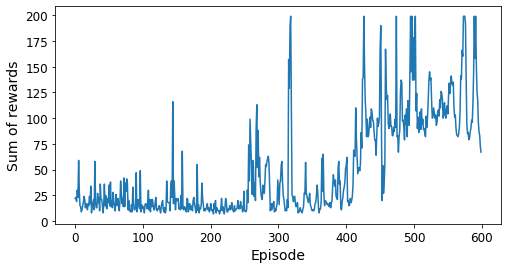

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [55]:
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
   

plot_animation(frames)

### Double DQN

In [56]:
# double DQN uses
# online model to choose the next best action
# and use target only for predicting next Q value for the best action

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [61]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=6e-3) # must fiddle aroudn with learning rate
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # chose the best next action with online model
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    
    # use target to predict Q values for next action
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                      (1- dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [62]:
replay_memory = deque(maxlen=2000)

In [63]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(
            episode, step+1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # you can also do soft updates at each step
    # if episode >= 50:
        # target_weights = target.get_weights()
        # online_weights = model.get_weights()
        # for index in range(len(target_weights)):
        #     target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        # target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 193, eps: 0.010

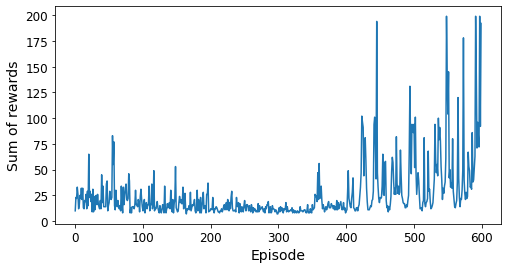

In [64]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [65]:
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

- one variation that can be added is importance sampling

### Dueling Double DQN

In [88]:
# first understand that
# Q(s,a) = V(s) + A(s, a)
# where V(s) = value of state s, and A(s, a) is the advantage of choosing a instead of other action
# if the best action is a'
# V(s) = Q(s, a'), because we assume best policy to do the best action
# so A(s, a') = 0
# Hence for dueling DQN, we subtract the max advantage from all advatantage, to set A(s, a') = 0

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [89]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [90]:
replay_memory = deque(maxlen=2000)

In [91]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 26, eps: 0.0100

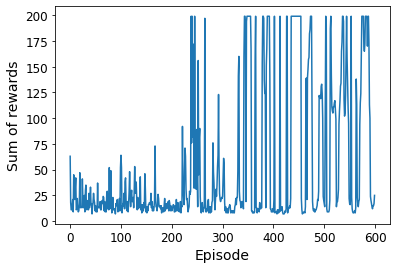

In [92]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [93]:
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [94]:
env.close()

### Using TF-Agents to Beat Breakout

In [4]:
!python3 -m pip install -U tf-agents
!python3 -m pip install -U 'gym[atari]'


Python
Python


In [ ]:
# use
# pip install --no-index -f https://github.com/Kojoley/atari-py/releases atari_py

In [8]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [9]:
env.gym

In [10]:
env.reset()

TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [11]:
env.step(1) # Fire

TimeStep(step_type=array(1), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

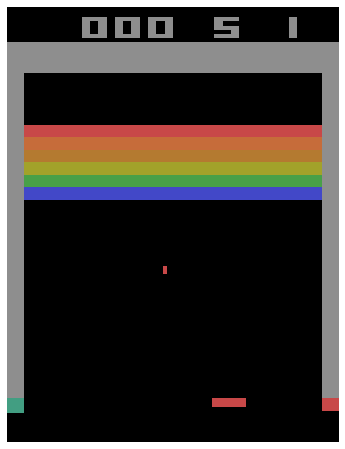

In [12]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [13]:
env.current_time_step()

TimeStep(step_type=array(1), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

#### Environment Specifications

In [14]:
# tf agents provide speficiation infos
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [15]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [16]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [18]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

#### Environment Wrappers

In [17]:
from tf_agents.environments.wrappers import ActionRepeat

# repeat action 4 times
repeating_env = ActionRepeat(env, times=4)
repeating_env

In [19]:
repeating_env.unwrapped

In [20]:
# list of available wrappers
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:.27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper Offsets actions to be zero-based.
ActionRepeat Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper Adds observation and action history to the environment's observations.
ObservationFilterWrapper Filters observations based on an array of indexes.
OneHotActionWrapper Converts discrete action to one_hot format.
PerformanceProfiler End episodes after specified number of steps.
PyEnvironmentBaseWrapper PyEnvironment wrapper forwards calls to the given environment.
RunStats Wrapper that accumulates run statistics as the environment iterates.
TimeLimit End episodes after specif

In [22]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)]
)

In [23]:
limited_repeating_env

In [24]:
limited_repeating_env.unwrapped

In [25]:
# create an Atari Breakout Environment

from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [26]:
env

In [27]:
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [28]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

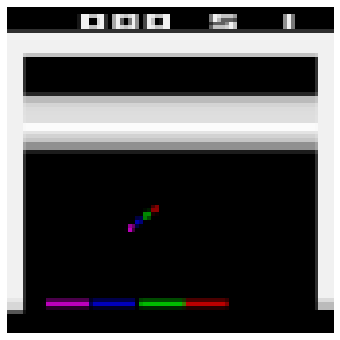

In [29]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
plt.show()

In [30]:
# convert the Python environment to a TF environment
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

#### Creating the DQN

In [31]:
# create the Q-Network
# image will be passed with floats from 0.0 to 1.0

from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                            lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
            tf_env.observation_spec(),
            tf_env.action_spec(),
            preprocessing_layers=preprocessing_layer,
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params)

In [33]:
# create DQN Agent
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # train every 4 collect steps
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps = 250000 // update_period, 
    end_learning_rate=0.01 # final epsilon
)
agent = DqnAgent(tf_env.time_step_spec(),
                tf_env.action_spec(), 
                q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000,
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99,
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step)
                )
agent.initialize()

In [34]:
# create replay buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000)

replay_buffer_observer = replay_buffer.add_batch

In [35]:
# simple custom observer
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [36]:
# training metrics
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [37]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [38]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [39]:
# collect driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [41]:
# collect initial experiences
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


20000/20000

In [42]:
# sample 2 sub-episodes, with 3 time steps each

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [43]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [44]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [45]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [46]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]])

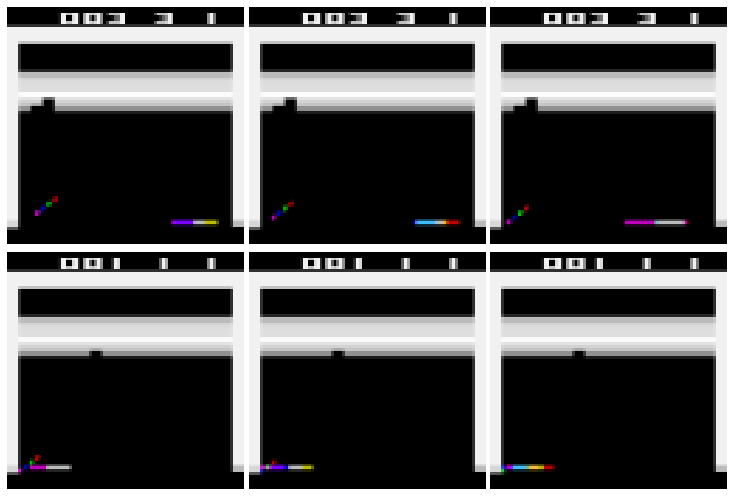

In [47]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
plt.show()

In [48]:
# create dataset
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [49]:
# convert main functions to TF functions
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [50]:
# run main loop

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [51]:
train_agent(n_iterations=50000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss:0.00671

INFO:absl: 
		 NumberOfEpisodes = 27
		 EnvironmentSteps = 4004
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 134.3000030517578


1998 loss:0.00651

INFO:absl: 
		 NumberOfEpisodes = 51
		 EnvironmentSteps = 8004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 170.39999389648438


2931 loss:0.00012

KeyboardInterrupt: 

In [54]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
%%html
<img src="images/rl/breakout.gif" />